# Excercise 2

## Import packages

In [3]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.exposure

import time
import math
import random

## Task 1
(2 points)
1. Use $f = loss(100)$ which creates a 1D array that mimics a loss curve of some neural network.
2. Implement the naive $\mathcal{O}(n w)$ mean filter to smooth the loss.
3. Implement the improved $\mathcal{O}(n)$ mean filter to smooth the loss.
4. Show all three curves in a single plot with a legend.
5. Compare the runtime between the naive and improved implementation.

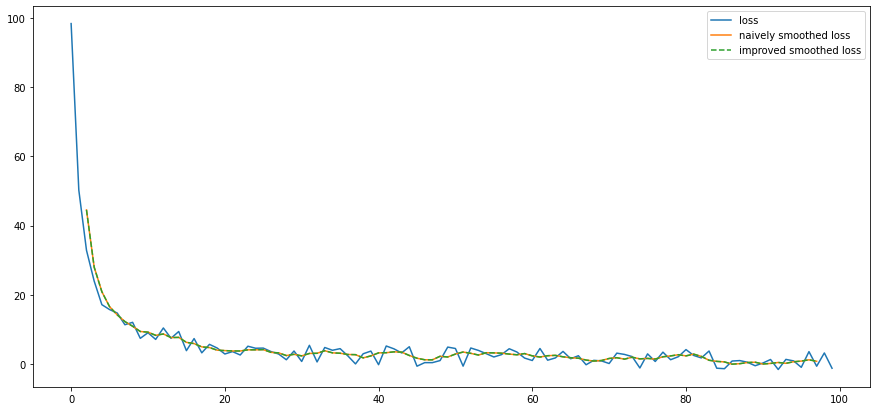

Time for the naive method:
129 µs ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Time for the improved method:
36.5 µs ± 7.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [2]:
# 1.
def loss(n):    
    return 1.0 / (0.01 * (np.arange(0, n) + 1)) + 3.0 * np.random.uniform(-1.00, 1.00, n)

# TODO: generate f with loss helper function
f = loss(100)

# 2.
def naive_running_mean(f, w):
    '''
    Apply the naive running mean filter and return the smoothed values.

    f -- contains the values
    w -- window size
    '''
    # initialize g
    g = np.zeros(len(f)-w+1)
    
    # half the kernel size
    h = int(w/2)
    
    for k in range(len(g)):
        kernel_sum = 0
        for j in range(k-h+2, k+h+3):
            kernel_sum += f[j]
        g[k] = kernel_sum/w
        
        
    return g

# 3.
def improved_running_mean(f, w):
    '''
    Apply the improved running mean filter and return the smoothed values.

    f -- contains the values
    w -- window size
    '''
    # initialize f_tilde
    f_tilde = np.zeros(len(f)+1)
    
    # half the kernel size
    h = int(w/2)
    
    # Precompute auxiliary function
    f_tilde[0] = 0
    for k, f_val in enumerate(f):
        f_tilde[k+1] = f_tilde[k] + f_val
        
    # Substraction step
    g =  (f_tilde[w:] - f_tilde[0:-w])/w
    
    return g

# 4.
ws = 5
h = int(ws/2)

plt.figure(figsize=(15,7))
plt.plot(f, label="loss")
plt.plot(np.arange(h,len(f)-h), naive_running_mean(f, ws), label="naively smoothed loss")
plt.plot(np.arange(h,len(f)-h), improved_running_mean(f, ws), "--", label="improved smoothed loss")
plt.legend()
plt.show()


# 5.

# TODO: Measure and print the runtime of both methods in Milliseconds
print("Time for the naive method:")
%timeit naive_running_mean(f, ws)
print("Time for the improved method:")
%timeit improved_running_mean(f, ws)


## Task 2
(4 points)
1. Create numpy arrays for the horizontal and vertical Sobel kernel.
$$
S_x =\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

$$
S_y =\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

2. Implement the $\textit{convolve}$ function with four nested loops.
3. Load the image from the last exercise and detect its edges using the Sobel kernels and the $\textit{convolve}$ function.
4. Implement the 1D $\textit{convolve_fast}$ function. Apply the seperated Sobel operators $u$ and $v$. Plot the result together with $\textit{convolve(S_x)}$ and compare the runtime.
5. Implement a function that seperates a 2D kernel into 2 1D kernels.
6. (Bonus) Use the function for a gaussian blur kernel and apply it on the image.

<span style="color:red"> We noticed Sx and Sy are swapped in the description above (compared to wikipedia) </span>

In [6]:
# 1
# TODO Create S_x and S_y

S_y = np.array([[-1, -2, -1],
                [ 0,  0,  0],
                [ 1,  2,  1]])

S_x = np.array([[-1,  0,  1],
                [-2,  0,  2],
                [-1,  0,  1]])


print('Horizontal Sobel kernel:\n', S_x)
print('Vertical Sobel kernel:\n', S_y)

Horizontal Sobel kernel:
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
Vertical Sobel kernel:
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


In [5]:
# 2
def convolve(arr, ker):
    '''
    Convolve the array using kernel K with four nested for loops.
    
    arr -- 2D array that gets convolved
    ker   -- kernel
    '''
    # get image size h x w
    h, w = np.shape(arr)
    
    # kernel size / padding
    s = np.shape(ker)[0]
    p = int(s/2)
    
    '''
    # optional normalization
    norm = np.sum(np.abs(ker))
    '''
    
    arr_conv = np.zeros([h-2*p,w-2*p])
    
    for i in range(h-2*p):
        for j in range(w-2*p):
            kernel_sum = 0
            for xi in range(s):
                for xj in range(s):
                    kernel_sum += arr[i+xi,j+xj] * ker[xi,xj]
            arr_conv[i,j] = kernel_sum #/ norm
    
    
    return arr_conv

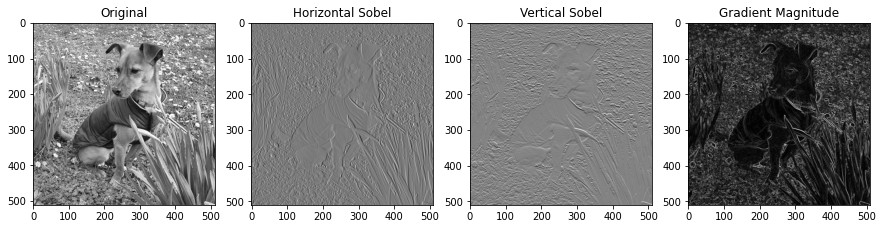

In [7]:
# 3
# TODO: load ./data/pepo.jpg as a grayscale image
image = skimage.io.imread("data/pepo.jpg")

# TODO: Convert the image to grayscale
gray = skimage.color.rgb2gray(image)
gray = gray / np.max(gray) # normalize the data to 0 - 1
gray = 255 * gray # Now scale by 255
gray = gray.astype(np.uint8)


# TODO: Use the Sobel filter for edge detection:
#       Compute the Gradient Magnitude using both Sobel kernels

xedges = convolve(gray, S_x)
xedges *= 255.0 / np.max(xedges)
yedges = convolve(gray, S_y)
yedges *= 255.0 / np.max(yedges)

edges = np.sqrt(xedges**2 + yedges**2)
edges *= 255.0 / np.max(edges)

xedges = xedges.astype('int32')
yedges = yedges.astype('int32')
edges = edges.astype('int32')

# Show results
_, axis = plt.subplots(1, 4, figsize=(15,10))
axis[0].imshow(gray, cmap='gray')
axis[0].set_title("Original")
axis[1].imshow(xedges,cmap='gray')
axis[1].set_title("Horizontal Sobel")
axis[2].imshow(yedges,cmap='gray')
axis[2].set_title("Vertical Sobel")
axis[3].imshow(edges,cmap='gray')
axis[3].set_title("Gradient Magnitude")
plt.show()

u   =
 [[1]
 [2]
 [1]]
v   =
 [[-1  0  1]]
S_x =
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


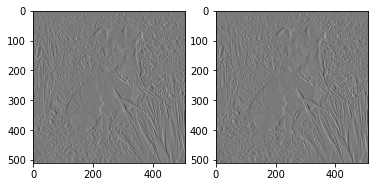

In [6]:
# 4
u = np.array([[1], [2], [1]])
v = np.array([[-1, 0, 1]])
S_x = np.dot(u, v)
print('u   =\n', u)
print('v   =\n', v)
print('S_x =\n', S_x)

def convolve_fast(arr, K_u, K_v):
    '''
    Convolve the array using kernel K_u and K_v.
    
    arr -- 2D array that gets convolved
    K_u -- kernel u
    K_v -- kernel v
    '''
    
    # get image size h x w
    h, w = np.shape(arr)
    
    # kernel size
    su = np.shape(K_u)[0]
    sv = np.shape(K_v)[1]
    p = int(su/2)
    
    # (intermediate) output
    aux = np.zeros([h-2*p,w])
    g = np.zeros([h-2*p,w-2*p])
    
    for i in range(h-2*p):
        for j in range(w):
            u_sum = 0
            for ui in range(su):
                u_sum += arr[i+ui,j]*K_u[ui,0]
            aux[i,j] = u_sum
            
    for i in range(h-2*p):
        for j in range(w-2*p):
            v_sum = 0
            for vi in range(sv):
                v_sum += aux[i,j+vi]*K_v[0,vi]
            g[i,j] = v_sum
    
    return g

edges_naive = xedges
edges_improved = convolve_fast(gray, u, v)
edges_improved *= 255.0 / np.max(edges_improved)
edges_improved = edges_improved.astype('int32')

# Show results
_, axis = plt.subplots(1, 2)
axis[0].imshow(edges_naive, cmap='gray')
axis[1].imshow(edges_improved,cmap='gray')
plt.show()

In [7]:
# TODO: Run both methods and compare their runtime

print("Time for naive convolution:")
%timeit convolve(gray, S_x)
print("Time for improved convolution:")
%timeit convolve_fast(gray, u, v)

Time for naive convolution:
6.58 s ± 89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time for improved convolution:
2.4 s ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# 5
print('rank of s_x:', np.linalg.matrix_rank(S_x))
print('rank of s_y:', np.linalg.matrix_rank(S_y))

def separate(K):
    '''
    Seperate the 2D kernel into 2 1D kernels.
    
    K -- 2D kernel
    '''
    U, D, VT = np.linalg.svd(K)
    K_u = U[:,0]/np.max(np.abs(U[:,0]))
    K_u = K_u[None].T
    K_v = VT[0,:]/np.max(np.abs(VT[0,:]))
    K_v = K_v[None]
    
    return K_u, K_v

K_u, K_v = separate(S_x)
print('K_u =\n', K_u)
print('K_v =\n', K_v)
print('K   =\n', np.dot(K_u, K_v))

rank of s_x: 1
rank of s_y: 1
K_u =
 [[-0.5]
 [-1. ]
 [-0.5]]
K_v =
 [[ 1.  0. -1.]]
K   =
 [[-0.5  0.   0.5]
 [-1.   0.   1. ]
 [-0.5  0.   0.5]]


In [10]:
# 6 Bonus
def gaussian_kernel(kernel_size, sigma):
    '''
    Return a 2D gaussian kernel.
    
    kernel_size -- size of the kernel
    sigma       -- sigma of the gaussian blur
    '''
   
    return h

# K = gaussian_kernel(15, 15)

# K_u, K_v = separate(K)

# # TODO: Run both methods and compare their runtime

# # Plot the results
# _, axis = plt.subplots(1, 2)
# axis[0].imshow(conv_x_naive, cmap='gray')
# axis[1].imshow(conv_x_improved,cmap='gray')
# plt.show()

## Task 3
(4 points)

1. Implement the naive max function using nested loops.
2. Implement the $\mathcal{O}(n log w)$ faster max function using a binary tree.

In [8]:
#1
def naive_max(arr, ws):
    '''
    Return the maximum-filtered array
    
    arr -- 2D array
    ws -- window size
    '''
    
    g = np.zeros(len(arr)-2*ws)
    
    for k in range(len(g)):
        maxi = arr[k]
        for ki in range(2*ws+1):
            val = arr[k+ki]
            if val > maxi:
                maxi = val
        g[k] = maxi
    
    return g

# Generate some random data to filter
f = []
for i in range(25):
    f.append(random.randint(0, 100))

print('input = ', f)
print('naive_max =', naive_max(f, 3))

input =  [100, 39, 82, 14, 89, 21, 92, 37, 82, 27, 95, 35, 63, 21, 67, 5, 6, 57, 99, 76, 33, 61, 66, 8, 83]
naive_max = [100.  92.  92.  92.  95.  95.  95.  95.  95.  95.  95.  67.  99.  99.
  99.  99.  99.  99.  99.]


In [26]:
#2
class Node:
    def __init__(self):
        self.max = -np.inf # value of this node
        self.top = None    # reference to parent node
        self.left = None   # left child node
        self.right = None  # right child node
        
        # HINT: this list will hold a reference to all leaf nodes that
        #       are children of this node.
        #       You will need later to add new and replace old values
        #       in the tree.
        self.elems = []   # list of all child leaf nodes
    
    
    def build_tree(self, depth, top=None):
        '''
        Build up a tree of certain depth
        
        depth -- tree depth
        top -- parent node
        '''
        self.top = top
        
        if depth > 0:
            # TODO: recursively initialize all children
            self.left = Node()
            self.left.build_tree(depth-1,self)
            self.right = Node()
            self.right.build_tree(depth-1,self)
           
            
            # TODO: concatenate elems lists of children
            # HINT: nodes that are not leafes should not be added
            #       to self.elems
            self.elems = self.left.elems + self.right.elems

        else:
            # TODO: this is a leaf node
            # HINT: this node has to be added to the elems list
            self.elems.append(self)
            
        
        return self.elems
    
    
    def update(self):
        '''
        Update the value (self.max) of this node
        and its parent nodes recursively
        '''
        self.max = max(self.left.max, self.right.max)
        if self.top is not None:
            self.top.update()
        
        # if self.right is None:
        #     if self.left is None:
        #         max_child = self.max
        #     else:
        #         max_child = self.left.max
        # elif self.left is None:
        #     max_child = self.right.max
        # else:
        #     max_child = np.max((self.left.max,self.right.max))

        # self.max = max_child
        # if self.top is not None:
        #     self.top.update()


class MaxTree:
    def __init__(self, ws):
        '''
        ws -- window size
        '''
        
        # TODO: compute number of leafes and tree depth (length = 2 * ws + 1)
        """added lenght & depth as global variabels for replace_elem()"""
        self.length = 2 * ws + 1
        depth = math.ceil(math.log(self.length, 2))
        
        
        # TODO: initialize root node
        self.root = Node()
        self.root.build_tree(depth)
        
        # init pointer to next element to be replaced
        self.ptr = 0
        
    def replace_elem(self, value):
        '''
        Replace an element (value of leaf node) in the tree

        value -- value of new element
        '''
        # HINT: use self.ptr as a pointer to the next
        #       element that has to be replaced

        self.root.elems[self.ptr].max = value
        self.root.elems[self.ptr].top.update()
        
        if self.ptr < self.length-1:
            self.ptr += 1
        else:
            self.ptr = 0

    def get_max(self):
        return self.root.max

#tree = MaxTree(3)

def fast_max(arr, ws):
    '''
    Return the maximum-filtered array
    
    arr -- 2D array
    ws -- window size
    '''
    max_arr = []
    
    # TODO: initialize tree
    tree = MaxTree(ws)
    
    # TODO: compute maximum-filtered output array
    for k in arr:
        tree.replace_elem(k)
        max_arr.append(tree.get_max())
    
    return max_arr[2*ws:]


print('input = ', f)
print('naive_max =', naive_max(f, 2))
print('fast_max =', fast_max(f, 2))

input =  [100, 39, 82, 14, 89, 21, 92, 37, 82, 27, 95, 35, 63, 21, 67, 5, 6, 57, 99, 76, 33, 61, 66, 8, 83]
naive_max = [100.  89.  92.  92.  92.  92.  95.  95.  95.  95.  95.  67.  67.  67.
  99.  99.  99.  99.  99.  76.  83.]
fast_max = [89, 89, 92, 92, 92, 92, 95, 95, 95, 95, 95, 67, 67, 67, 99, 99, 99, 99, 99, 76, 83]


We now use your implementation to filter an image with different window sizes.
Note, that for small windows, the naive method is indeed faster due to the lower overhead.
However, as it has a much better time complexity, the tree method is much faster for large windows.

<span style="color:red"> We did not implement the filters with padding thus the image is getting smaller. </span>


Filter with window size 2
Naive implementation took 786.790 ms
Improved implementation took 1743.474 ms


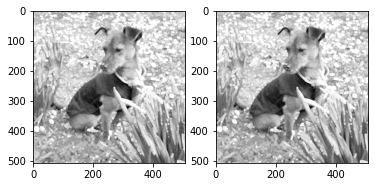


Filter with window size 4
Naive implementation took 987.545 ms
Improved implementation took 1763.606 ms


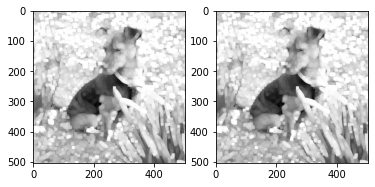


Filter with window size 8
Naive implementation took 1484.962 ms
Improved implementation took 2069.592 ms


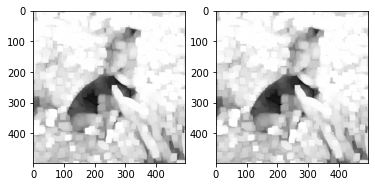


Filter with window size 16
Naive implementation took 2708.195 ms
Improved implementation took 2165.481 ms


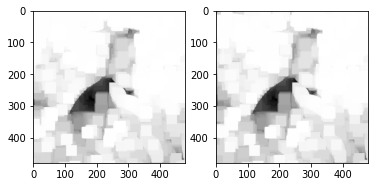


Filter with window size 32
Naive implementation took 3777.039 ms
Improved implementation took 2338.940 ms


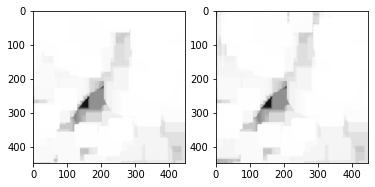

In [27]:
# Nothing to do here ;)
def image_max(arr, ws, method):
    '''
    Apply a max-filter to an image
    
    arr -- input image
    ws -- window size
    method -- filter function
    '''
    # out = np.zeros_like(arr)
    aux = np.zeros((arr.shape[0],arr.shape[1]-2*ws))       # Added
    out = np.zeros((arr.shape[0]-2*ws,arr.shape[1]-2*ws))  # Changed
    
    for y in range(arr.shape[0]):
        aux[y] = method(arr[y], ws)
    
    for x in range(arr.shape[1]-2*ws):
        out[:, x] = method(aux[:, x], ws)
    
    
    return out

for ws in [2, 4, 8, 16, 32]:
    print('\nFilter with window size {}'.format(ws))
    start_time = time.time()
    max_img_naive = image_max(gray, ws, naive_max)
    naive_time = time.time() - start_time
    print('Naive implementation took {:.3f} ms'.format(1000 * naive_time))

    start_time = time.time()
    max_img_improved = image_max(gray, ws, fast_max)
    improved_time = time.time() - start_time
    print('Improved implementation took {:.3f} ms'.format(1000 * improved_time))

    _, axis = plt.subplots(1, 2)
    axis[0].imshow(max_img_naive, cmap='gray')
    axis[1].imshow(max_img_improved,cmap='gray')
    plt.show()